In [55]:
import jax.numpy as np
from jax.scipy.stats.norm import cdf,pdf,ppf
from jax import vmap,jit
import matplotlib.pyplot as plt
from jax.lax import cond,scan,while_loop
from functools import partial


def db_while_loop(cond_func,body_func,init_val):
    val = init_val
    while cond_func(val):
        val = body_func(val)
    return val


@partial(jit,static_argnums = (0,-1))
def bisect(f,a,b,eps,offset,max_iter):
  def choose_bin(fa,fc,fb,a,c,b,offset,j):
    return cond( fa*fc > 0., lambda x: (fc,fb,c,b,offset,j+1),lambda x: (fa,fc,a,c,offset,j+1),None)
  def body_fun(val):
    fa,fb,a,b,offset,j = val
    c = (a + b)/2
    fc = f(c) - offset
    return choose_bin(fa,fc,fb,a,c,b,offset,j)
  def cond_fun(val):
    fa,fb,a,b,_,j = val
    resa = cond(abs(fa) < eps,lambda x: 1,lambda x: 0,None)
    resb = cond(abs(fb) < eps,lambda x: 1,lambda x: 0,None)
    resFin = cond(j > max_iter,lambda x: 1,lambda x: 0,None)
    #print("Max iter reached?",resFin)
    return (resa + resb + resFin) == 0
  init_val = (f(a)-offset,f(b)-offset,a,b,offset,0)
  out = while_loop(cond_fun,body_fun,init_val)
  fa,fb,a,b,_,_ = out
  return cond(abs(fa) < eps,lambda x: a,lambda x: b,None)


from jax.scipy.optimize import minimize

L1 = 1.
L2 = 1.5
BETA = 100.
ETA = 1.


def Aneq(eps,tau,beta):
    return cond(tau > 0.,lambda n: eps**4/4 + (L1 - L2)*eps**3/3 - L1*L2*eps**2/2 + tau**2*(3/2*eps**2 + (L1 - L2)*eps - L1*L2/2 ) + 3/4*tau**4 - 1/2/beta*np.log(tau**2), lambda n: np.inf,None)

def AneqNoInf(eps,tau,beta):
    return eps**4/4 + (L1 - L2)*eps**3/3 - L1*L2*eps**2/2 + tau**2*(3/2*eps**2 + (L1 - L2)*eps - L1*L2/2 ) + 3/4*tau**4 - 1/2/beta*np.log(tau**2)


def fneq(eps,tau,beta):
    return -cond(tau > 0.,lambda n: eps**3 + (L1 - L2)*eps**2 - L1*L2*eps + tau**2*(3*eps + (L1-L2)),lambda n: -np.inf,None)

def kneq(eps,tau,beta):
    return cond(tau > 0.,lambda n: 3*eps**2 + 2*(L1 - L2)*eps - L1*L2 + 3*tau**2,lambda n: np.inf,None)

def phiToTau(eps,phi):
    return eps/ppf(phi)

def tauToPhi(eps,tau):
    return cdf(eps/tau)

def AneqPhi(eps,phi,beta):
    return Aneq(eps,phiToTau(eps,phi),beta)


def AneqPhiOnly(phi,beta):
    eps = np.linspace(-3,3,1000)
    return np.min(vmap(AneqPhi,in_axes = (0,None,None))(eps,phi,beta))


r0 = np.sqrt(4 + np.log(.2)**2)
theta0 = np.arccos(2/r0)

thetas = np.linspace(-1.5*theta0,np.pi + 2*theta0,1000)
rs = np.zeros_like(thetas)
for i,t in enumerate(thetas):
    
    rads = np.linspace(0,4,10000)
    vals = vmap(AneqNoInf,in_axes = (0,0,None))(rads*np.cos(t),np.exp(np.log(0.05) + rads*np.sin(t)),BETA)
    ind = np.where(vals == np.min(vals))[0][0]
    rs = rs.at[i].set(rads[ind])
    #plt.plot(rads*np.cos(t),0.05*np.exp(rads*np.sin(t)),zorder = 10)
    #plt.scatter([rads[ind]*np.cos(t),],[0.05*np.exp(rads[ind]*np.sin(t)),],zorder = 11,marker = "x")

eps = np.linspace(-2,2,200)
taus = np.logspace(-2,1,200)

eps,taus = np.meshgrid(eps,taus)

aNeqs = vmap(Aneq,in_axes = (0,0,None))(eps.flatten(),taus.flatten(),BETA)
aNeqs = aNeqs.reshape(eps.shape)



vals = vmap(Aneq,in_axes = (0,0,None))(rs*np.cos(thetas),0.05*np.exp(rs*np.sin(thetas)),BETA)
i1 = np.where(vals == np.min(vals))[0][0]
i2 = np.where(vals[500:] == np.min(vals[500:]))[0][0]
i2 = i2 + 501
rs = rs[i1:i2]
thetas = thetas[i1:i2]

minFEeps = rs*np.cos(thetas)
minFEtaus = 0.05*np.exp(rs*np.sin(thetas))





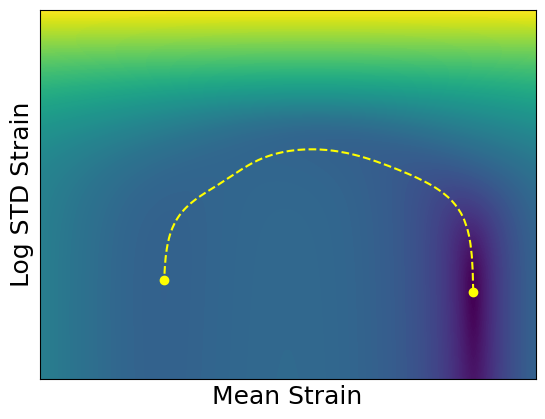

In [56]:
cbar = plt.contourf(eps,taus,np.log10(aNeqs - np.min(aNeqs) + 0.01),cmap = "viridis",levels = 200)
#plt.colorbar(cbar)
plt.yscale("log")
plt.tick_params(
    axis = "x",
    which = "both",
    bottom = False,
    top = False,
    labelbottom = False)
plt.tick_params(
    axis = "y",
    which = "both",
    left = False,
    right = False,
    labelleft = False)

plt.plot(minFEeps,minFEtaus,color = "yellow",linestyle = "dashed")
plt.scatter([minFEeps[0],minFEeps[-1]],[minFEtaus[0],minFEtaus[-1]],color = "yellow",marker = "o")
plt.xlim([-2.,2.])
plt.ylim([0.01,10.])
plt.xlabel("Mean Strain",fontsize = 18)
plt.ylabel("Log STD Strain",fontsize = 18)
plt.savefig("Fig1A.png",dpi = 500)
plt.show()

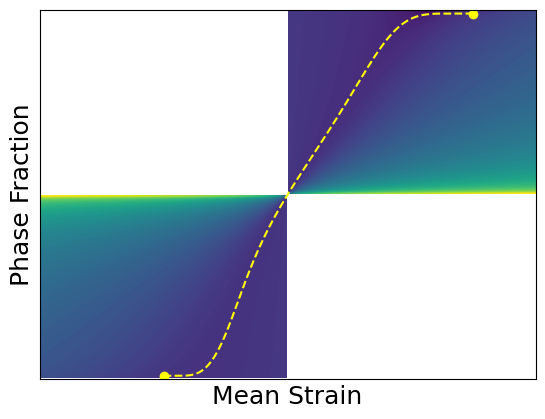

In [59]:

minFEphis = cdf(minFEeps/minFEtaus)
minFEphis = 0.01 + .98*minFEphis  # linearly altered just to fit on the screen

eps = np.linspace(-2,2,200)
phis = np.linspace(0,1,200)
eps,phis = np.meshgrid(eps,phis)
aNeqs = vmap(AneqPhi,in_axes = (0,0,None))(eps.flatten(),phis.flatten(),BETA)
aNeqs = aNeqs.reshape(eps.shape)

cbar = plt.contourf(eps,phis,np.log10(aNeqs - np.min(aNeqs) + 0.01),cmap = "viridis",levels = 200)
#plt.colorbar(cbar)
plt.tick_params(
    axis = "x",
    which = "both",
    bottom = False,
    top = False,
    labelbottom = False)
plt.tick_params(
    axis = "y",
    which = "both",
    left = False,
    right = False,
    labelleft = False)
plt.plot(minFEeps,minFEphis,color = "yellow",linestyle = "dashed")
plt.scatter([minFEeps[0],minFEeps[-1]],[minFEphis[0],minFEphis[-1]],color = "yellow",marker = "o")
plt.xlabel("Mean Strain",fontsize = 18)
plt.ylabel("Phase Fraction",fontsize = 18)
plt.savefig("Fig1B.png",dpi = 500)
plt.show()

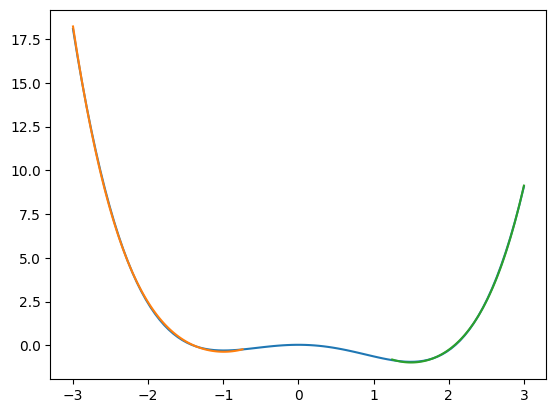

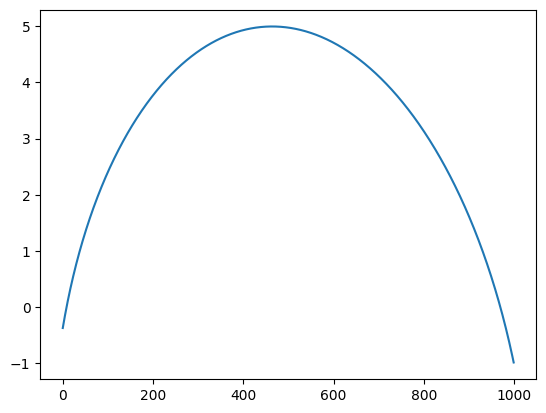

In [117]:
lLeft = -minFEeps[-1]
lRight = minFEeps[0]
tauLeft = minFEtaus[-1]
tauRight = minFEtaus[0]


xL = np.linspace(-3.,-lLeft+.25,100) + lLeft
X = np.array([[x**i for i in [0,2,4]] for x in xL])
U,s,Vh = np.linalg.svd(X,full_matrices = False)
ys = vmap(Aneq,in_axes = (0,None,None))(xL - lLeft,tauLeft,BETA)
cL = Vh.conj().T @ np.diag(1/s) @ U.conj().T @ ys

xR = np.linspace(lRight -.25,3.,100) - lRight
X = np.array([[x**i for i in [0,2,4]] for x in xR])
U,s,Vh = np.linalg.svd(X,full_matrices = False)
ys = vmap(Aneq,in_axes = (0,None,None))(xR + lRight,tauRight,BETA)
cR = Vh.conj().T @ np.diag(1/s) @ U.conj().T @ ys



pnts = np.linspace(-3,3,100)
vals = vmap(Aneq,in_axes = (0,None,None))(pnts,tauLeft,BETA)
plt.plot(pnts,vals)
plt.plot(xL-lLeft,cL[0] + cL[1]*xL**2 + cL[2]*xL**4)
plt.plot(xR+lRight,cR[0] + cR[1]*xR**2 + cR[2]*xR**4)
plt.show()




#comment = """

def regFE(eps,phi,c = 1.):
    return (cL[0] + cL[1]*(eps + lLeft)**2 + cL[2]*(eps+lLeft)**4)*(1 - phi) + (cR[0] + cR[1]*(eps - lRight)**2 + cR[2]*(eps - lRight)**4)*phi + c*phi*(1 - phi)

def regFEinf(eps,phi,c=1.):
    return cond(abs(2*phi - 1) < 1.,lambda n: regFE(eps,phi,c),lambda n: 1000.,None)


c0 = 1.
regFEinf1 = lambda eps,phi: regFE(eps,phi,c = c0)

minFEphis1 = np.linspace(0,1,1000)
minFEeps1 = np.zeros_like(minFEphis1)
for i,p in enumerate(minFEphis1):
    es = np.linspace(-2,2,10000)
    vals = vmap(regFEinf1,in_axes = (0,None))(es,p)
    ind = np.where(vals == np.min(vals))[0][0]
    minFEeps1 = minFEeps1.at[i].set(es[ind])
vals = vmap(regFEinf1)(minFEeps1,minFEphis1)
plt.plot(vals)
plt.show()


eps = np.linspace(-2,2,200)
phis = np.linspace(0,1,200)
eps,phis = np.meshgrid(eps,phis)

aNeqs = regFE(eps.flatten(),phis.flatten(),c = 200.)
aNeqs = aNeqs.reshape(eps.shape)
#"""

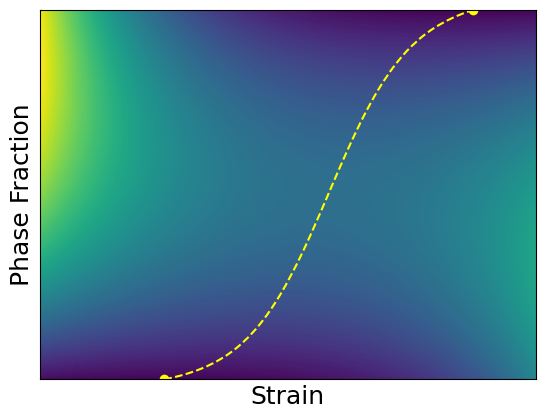

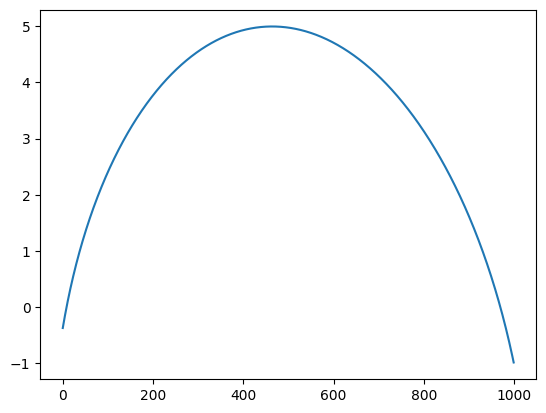

In [118]:
plt.contourf(eps,phis,aNeqs,cmap = "viridis",levels = 200)
plt.tick_params(
    axis = "x",
    which = "both",
    bottom = False,
    top = False,
    labelbottom = False)
plt.tick_params(
    axis = "y",
    which = "both",
    left = False,
    right = False,
    labelleft = False)
plt.plot(minFEeps1,minFEphis1,color = "yellow",linestyle = "dashed")
plt.scatter([minFEeps1[0],minFEeps1[-1]],[minFEphis1[0],minFEphis1[-1]],color = "yellow",marker = "o")
plt.xlabel("Strain",fontsize = 18)
plt.ylabel("Phase Fraction",fontsize = 18)
plt.savefig("Fig1C.png",dpi = 500)
plt.show()

plt.plot(vals)
plt.show()

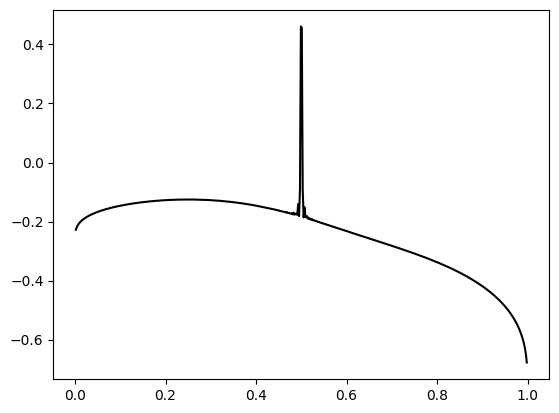

In [4]:
phis = np.linspace(0,1,500)
aNeqs = vmap(AneqPhiOnly,in_axes = (0,None))(phis,BETA)
plt.plot(phis,aNeqs,color = "k")
plt.show()

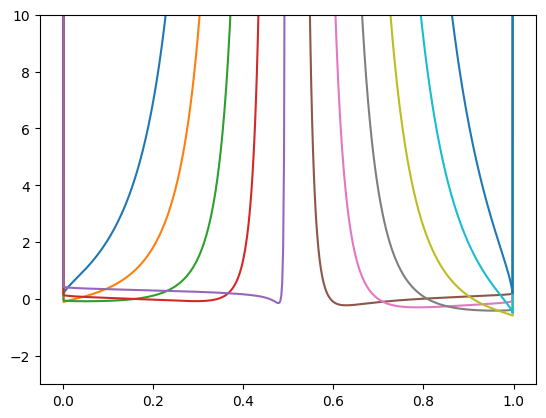

In [35]:
vals = []
eps = np.linspace(-L1 - .2,L2 + .2,11)
for e in eps:
    vals.append(vmap(AneqPhi,in_axes = (None,0,None))(e,phis,BETA))

for v in vals:
    plt.plot(phis,v)

plt.ylim([-3,10])
plt.show()

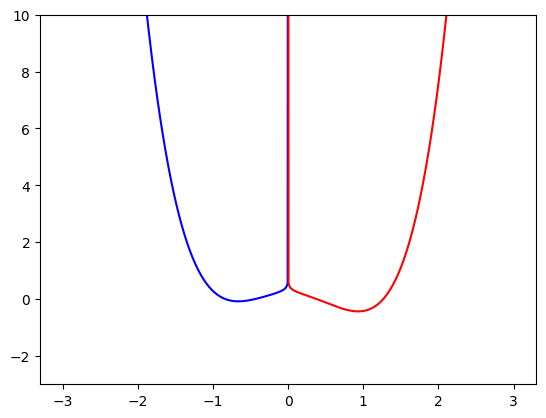

In [36]:
eps = np.linspace(-3,3,500)
aNeqL = vmap(AneqPhi,in_axes = (0,None,None))(eps,0.05,BETA)
aNeqR = vmap(AneqPhi,in_axes = (0,None,None))(eps,.95,BETA)

plt.plot(eps,aNeqL,color = "blue")
plt.plot(eps,aNeqR,color = "red")
plt.ylim([-3,10])
plt.show()

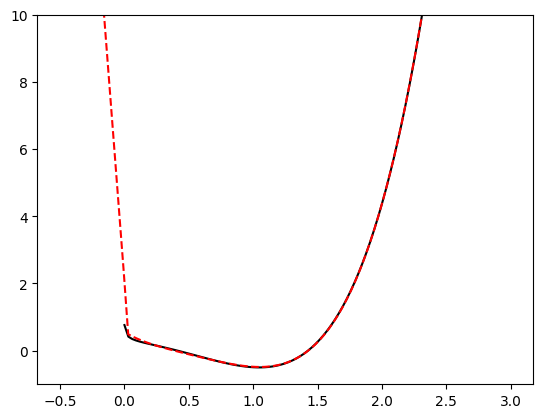

[ 0.55453825 -2.297924    3.7988281  -5.146759    3.2089844  -0.6638336
  0.06707668]


In [47]:
xs = np.linspace(0.001,3.0,100)
X = np.array([[x**i for i in range(7)] for x in xs])
U,s,Vh = np.linalg.svd(X,full_matrices = False)
ys = vmap(AneqPhi,in_axes = (0,None,None))(xs,0.98,BETA)
c = Vh.conj().T @ np.diag(1/s) @ U.conj().T @ ys

def poly(x,c):
    return x**np.arange(len(c)) @ c


def fit(x,c):
    return cond(x > 0.03, lambda n: poly(x,c), lambda n: -50*(x - 0.03) + poly(-0.03,c),None)



vpoly = vmap(fit,in_axes = (0,None))

pnts = np.linspace(-.5,3,100)
us = vpoly(pnts,c)

plt.plot(xs,ys,color = "k")
plt.plot(pnts,us,color = "r",linestyle = "dashed")
plt.ylim([-1,10])
plt.show()
print(c)